In [55]:
#!pip install git+https://github.com/PawPol/PyPortOpt.git@main

In [56]:
#!pip install quandl
#!pip install pandahouse
#!pip install openpyxl

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import pandas.io.data as web
#from pandas_datareader import data as web
import scipy.optimize as sco
import quandl
import math
from PyPortOpt import Optimizers as o
from scipy import sparse
import osqp
import quantstats as qs
import pandahouse as ph
import openpyxl

In [2]:
def generate_query(Ticker):
    """
        function to get the sql query
        
        Parameters
        ----------
        Ticker: List
            A list of tickers
            
        Returns
        -------
        q : string
            sql query 
    """
    if Ticker:
        q = "select Ticker, Date, Adjusted_Close from portfolio.eod where Ticker in ("

        if len(Ticker) > 1:
            for i in range(len(Ticker)-1):
                q+= "'"+Ticker[i]+"',"

            q+= "'"+Ticker[i+1]+"')"
        elif len(Ticker) == 1: 
            q+= "'"+Ticker[0]+"')"

        q+= " and yr_nbr in (2018,2019,2020,2021,2022);" # Change this for appropriate date range
        return q 

In [3]:
df_ticker = pd.read_excel("C:/Users/16468/Documents/Stony Brook/Executive Education/MySlides/Code/sp_500.xlsx")
assets = df_ticker['Ticker']
assets = assets[:200]
a = assets.values.tolist()

In [4]:
connection = dict(database='portfolio',
                  host='http://ppolak.ams.stonybrook.edu:8123',
                  user='remoteuser',
                  password='password')
q = generate_query(a)
data = ph.read_clickhouse(q, connection=connection)

In [8]:
# here put your data download

In [9]:
data

,EOD/AMZN - Adj_Close,EOD/MSFT - Adj_Close,EOD/GOOGL - Adj_Close,EOD/F - Adj_Close,EOD/TM - Adj_Close,EOD/AAPL - Adj_Close,EOD/KO - Adj_Close,EOD/PEP - Adj_Close
Date,,,,,,,,
2015-01-02,308.52,41.412957,529.55,11.238559,104.066073,24.779987,33.822579,77.461983
2015-01-05,302.19,41.027700,519.46,10.799552,102.161466,24.081896,33.822579,76.879624
2015-01-06,295.29,40.429886,506.64,10.697118,101.109792,24.084162,34.079418,76.297265
2015-01-07,298.42,40.943563,505.15,11.004422,103.652028,24.421875,34.504809,78.528275
2015-01-08,300.46,42.148046,506.91,11.282459,105.647725,25.360219,34.922174,79.955465
...,...,...,...,...,...,...,...,...
2021-10-25,3320.37,308.130000,2748.94,16.000000,172.230000,148.640000,54.230000,159.220000
2021-10-26,3376.07,310.110000,2786.17,15.940000,173.200000,149.320000,54.470000,161.170000
2021-10-27,3392.49,323.170000,2924.35,15.510000,174.090000,148.850000,55.520000,160.610000


In [64]:
def minimumVariancePortfolio(sigMat, maxAlloc, longShort, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None):
    d = sigMat.shape[0]
    
    if assetsOrder:
        temp = sigMat[:,assetsOrder]
        sigMat = temp[assetsOrder,:]
        
    if lambda_l1 < 0:
        msg = (
                "lambda_l1 must either be None negative, "
                f"{lambda_l1} was passed"
                )
        raise ValueError(msg)
    if lambda_l2 < 0:
        msg = (
                "lambda_l2 must either be None negative, "
                f"{lambda_l2} was passed"
                )
        raise ValueError(msg)
    if len(sigMat) != len(sigMat[0]):
        msg = (
                "sigMat must be suqre matrix"
                ) 
        raise ValueError(msg)
    if lambda_l2:
        sigMat_l2  = o.sigMatShrinkage(sigMat,lambda_l2)
        sigMat_l2, e_min  = o.SymPDcovmatrix(sigMat_l2)
    else:
        sigMat, e_min  = o.SymPDcovmatrix(sigMat)
    
    if longShort==0:
        Aeq = np.ones(d)
        Beq = 1
        LB = np.zeros(d)
        UB = maxAlloc*np.ones(d)
        if assetsOrder:
            L_ine = -np.ones(d-1)
            D = np.eye(d-1, d)
            for i in range(d-1):
                D[i, i+1] = -1
            A = -1*D
            B = np.zeros(d-1)
            A = np.vstack([A, Aeq, np.eye(d)])
            l = np.hstack([L_ine, Beq, LB])
            u = np.hstack([B, Beq, UB])
        else:
            A = np.vstack([Aeq, np.eye(d)])
            l = np.hstack([Beq, LB])
            u = np.hstack([Beq, UB])
            
        if lambda_l1:
            meanVec = -lambda_l1*np.ones(d)
        else:
            meanVec = -np.zeros(d)
        if lambda_l2:
            P = sparse.csc_matrix(sigMat_l2)
        else:
            P = sparse.csc_matrix(sigMat)
        A = sparse.csc_matrix(A)
        prob = osqp.OSQP()
        # Setup workspace
        prob.setup(P, -meanVec, A, l, u, verbose = False, max_iter = 10000, eps_abs=1e-8, eps_rel = 1e-8,eps_prim_inf = 1e-8,eps_dual_inf = 1e-8)
        # Solve problem
        #print(-meanVec)
        res = prob.solve()
        w_opt = res.x
        if not w_opt.all():
            w_opt=np.ones(d)/d
    
    elif longShort != 0:
        A = np.hstack([np.zeros(d), np.ones(d), np.zeros(d)])
        B = 1 + abs(longShort)
        Grenze = min(abs(longShort),maxAlloc)
        if assetsOrder:
            L_ine = np.hstack([0, -(1+2*Grenze)*np.ones(d-1)])
            D = np.eye(d-1, d)
            for i in range(d-1):
                D[i, i+1] = -1
            A = np.vstack([A,
                np.hstack([-1*D, np.zeros((d-1, 2*d))])
            ])
            B = np.hstack([B, np.zeros(d-1)])
        else:
            L_ine = 0
        Aeq = np.vstack([
            np.hstack([np.eye(d), -np.eye(d), np.eye(d)]),
            np.hstack([np.ones(d), np.zeros(d), np.zeros(d)])
        ])
        Beq = np.hstack([np.zeros(d), 1])
        LB = np.hstack([-Grenze*np.ones(d), np.zeros(2*d)])
        UB = maxAlloc*np.ones(3*d)
        if lambda_l2:
            sigMat3d = np.vstack([
            np.hstack([sigMat_l2, np.zeros((d,2*d))]),
            np.zeros((2*d,3*d))
            ])
        else:
            sigMat3d = np.vstack([
                np.hstack([sigMat, np.zeros((d,2*d))]),
                np.zeros((2*d,3*d))
            ])
        
        sigMat3d = sigMat3d +np.diag(np.hstack([-0.1*e_min*np.ones(d),0.1*e_min*np.ones(2*d)]))
        #import pdb; pdb.set_trace()
        if lambda_l1:
            meanvec3d = np.hstack([np.zeros(d), -lambda_l1*np.ones(2*d)])
        else:
            meanvec3d = np.hstack([np.zeros(d), np.zeros(2*d)])

        A = np.vstack([A, Aeq, np.eye(3*d)])
        l = np.hstack([L_ine, Beq, LB])
        u = np.hstack([B, Beq, UB])

        A = sparse.csc_matrix(A)
        sigMat3d = sparse.csc_matrix(sigMat3d)

        prob = osqp.OSQP()
        # Setup workspace
        prob.setup(sigMat3d, -meanvec3d, A, l, u, verbose = False, eps_abs=1e-8, eps_rel = 1e-8,eps_prim_inf = 1e-8,eps_dual_inf = 1e-8)
        # Solve problem
        res = prob.solve()
        wuv_opt = res.x
        if not wuv_opt.all():
            w_opt=np.ones(d)/d
        else:
            w_opt = wuv_opt[:d]
    

    t = np.dot(w_opt, sigMat)
    Var_opt = np.dot(t, w_opt.transpose())
    if assetsOrder:
        w_opt = w_opt[assetsOrder]
    #if exitflag!=1:
        #print("minimumVariancePortfolio: Exitflag different than 1 in quadprog")
    return w_opt, Var_opt

In [65]:
def maxSharpeRatioPortfolio(meanVec, sigMat, maxAlloc, longShort, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None):
    d = sigMat.shape[0]
    if assetsOrder:
        temp = sigMat[:,assetsOrder]
        sigMat = temp[assetsOrder,:]
        meanVec = meanVec[assetsOrder]
    if lambda_l2:
        sigMat_l2 = o.sigMatShrinkage(sigMat,lambda_l2)
        sigMat_l2, e_min  = o.SymPDcovmatrix(sigMat_l2)
    else:
        sigMat, e_min  = o.SymPDcovmatrix(sigMat)
        
    if longShort==0:
        if sum(meanVec>0) == 0:
            exitflag=-10
            w_opt = np.zeros(d)
            Var_opt = 0
            return
        Aeq = np.vstack([
            np.hstack([np.ones(d), -1]),
            np.hstack([meanVec.transpose(), 0])
        ])
        Beq = np.hstack([0, 1])
        LB = np.hstack([np.zeros(d), -1])
        UB = maxAlloc*np.ones(d)
        Awuv = np.vstack([-np.eye(d), np.zeros(d), np.eye(d)])
        Bwuv = np.hstack([-LB, UB]) #not sure
        #[w u v kappa] where kappa>0 is a scalar for the rescaling
        Awuvk = np.hstack([Awuv, -Bwuv.transpose().reshape(len(Bwuv), 1)])
        Bwuvk = np.zeros(len(Bwuv))
        Bwuvk[d]=-1e-12
        LB = []
        UB = []
        if assetsOrder:
            L_ine = np.hstack([-np.inf*np.ones(2*d+1), -np.ones(d-1)])
            D = np.eye(d-1, d)
            for i in range(d-1):
                D[i, i+1] = -1
            Dk = np.hstack([-1*D, np.zeros((d-1,1))])
            Awuvk = np.vstack([Awuvk, Dk])
            Bwuvk = np.hstack([Bwuvk, np.zeros(d-1)])
        else:
            L_ine = -np.inf*np.ones(2*d+1)
        
        if lambda_l2:
            Sigmat_zk = np.vstack([
                np.hstack([sigMat_l2, np.zeros((d,1))]),
                np.zeros(d+1)
            ])
        else:
            Sigmat_zk = np.vstack([
                np.hstack([sigMat, np.zeros((d,1))]),
                np.zeros(d+1)
            ])
        
        if lambda_l1:
            meanVec_zk = -lambda_l1*np.hstack([np.ones(d), 0])
        else:
            meanVec_zk = -np.zeros(d+1)
        #import pdb; pdb.set_trace()
        A = np.vstack([Awuvk, Aeq])
        l = np.hstack([L_ine, Beq, LB])
        u = np.hstack([Bwuvk, Beq, UB])
        P = sparse.csc_matrix(Sigmat_zk)
        A = sparse.csc_matrix(A)
        prob = osqp.OSQP()
        # Setup workspace
        prob.setup(P, -meanVec_zk, A, l, u, verbose = False, max_iter = 10000, eps_abs=1e-8, eps_rel = 1e-8,eps_prim_inf = 1e-8,eps_dual_inf = 1e-8)
        # Solve problem
        #print(-meanVec_zk)
        res = prob.solve()
        zk_opt = res.x
        w_opt = zk_opt[:d]/zk_opt[d]
        
    elif longShort != 0:
        if sum(meanVec>0) == 0:
            exitflag=-10
            w_opt = np.zeros(d)
            Var_opt = 0
            return
        Grenze = min(abs(longShort),maxAlloc)
        LB = np.hstack([-1*Grenze*np.ones(d),np.zeros(2*d),-1])
        UB = maxAlloc*np.ones(3*d)
        Awuv = np.vstack([
            np.hstack([np.zeros(d), np.ones(d), np.zeros(d)]),
            np.hstack([-np.eye(d), np.zeros((d,d)), np.zeros((d,d))]),
            np.hstack([np.zeros((d,d)), -np.eye(d), np.zeros((d,d))]),
            np.hstack([np.zeros((d,d)), np.zeros((d,d)), -np.eye(d)]),
            np.hstack([np.zeros(d), np.zeros(d), np.zeros(d)]),
            np.hstack([np.eye(d), np.zeros((d,d)), np.zeros((d,d))]),
            np.hstack([np.zeros((d,d)), np.eye(d), np.zeros((d,d))]),
            np.hstack([np.zeros((d,d)), np.zeros((d,d)), np.eye(d)])
        ])
        Bwuv = np.hstack([1 + abs(longShort), -LB, UB])
        Awuvk = np.hstack([Awuv, -Bwuv.reshape(-1,1)])
        Bwuvk = np.zeros(len(Bwuv))
        Bwuvk[3*d+1] = -1e-12
        LB = []
        UB = []
        Aeq = np.vstack([
            np.hstack([np.eye(d), -np.eye(d), np.eye(d), np.zeros((d,1))]),
            np.hstack([np.ones(d), np.zeros(d), np.zeros(d), -1]),
            np.hstack([meanVec, np.zeros(d), np.zeros(d), 0])
        ])
        Beq = np.hstack([np.zeros(d), 0, 1])
        if assetsOrder:
            D = np.eye(d-1, d)
            for i in range(d-1):
                D[i, i+1] = -1
            Dk = np.hstack([-1*D, np.zeros((d-1, 2*d)), np.zeros((d-1, 1))])
            Awuvk = np.vstack([Awuvk, Dk])
            Bwuvk = np.hstack([Bwuvk, np.zeros(d-1)])
            L_ine = np.hstack([0, -1*np.inf*np.ones(6*d + 1), -(1+2*Grenze)*np.ones(d-1)])
        else:
            L_ine = np.hstack([0, -1*np.inf*np.ones(6*d + 1)])
        
        if lambda_l2:
            sigMat3d = np.vstack([
                np.hstack([sigMat_l2, np.zeros((d,2*d))]),
                np.zeros((2*d,3*d))
            ])
        else:
            sigMat3d = np.vstack([
                np.hstack([sigMat, np.zeros((d,2*d))]),
                np.zeros((2*d,3*d))
            ])
            
        sigMat3d = sigMat3d +np.diag(np.hstack([-0.1*e_min*np.ones(d),0.1*e_min*np.ones(2*d)]))
        sigMat3dk = np.vstack([
            np.hstack([sigMat3d, np.zeros((3*d, 1))]),
            np.zeros(3*d + 1)
        ])
        
        if lambda_l1:
            meanvec3dk = np.hstack([np.zeros(d), -lambda_l1*np.ones(2*d), 0])
        else:
            meanvec3dk = np.hstack([np.zeros(d), np.zeros(2*d), 0])
        
        A = np.vstack([Awuvk, Aeq])
        l = np.hstack([L_ine, Beq, LB])
        u = np.hstack([Bwuvk, Beq, UB])
        A = sparse.csc_matrix(A)
        sigMat3dk = sparse.csc_matrix(sigMat3dk)
        prob = osqp.OSQP()
        # Setup workspace
        prob.setup(sigMat3dk, -meanvec3dk, A, l, u, verbose = False, eps_abs=1e-8, eps_rel = 1e-8,eps_prim_inf = 1e-8,eps_dual_inf = 1e-8)
        # Solve problem
        res = prob.solve()
        wuvk_opt = res.x
        if not wuvk_opt.all():
            w_opt=np.ones(d)/d
        else:
            w_opt = wuvk_opt[:d]/wuvk_opt[3*d]
        
    t = np.dot(w_opt, sigMat)
    Var_opt = np.dot(t, w_opt.transpose())
    if assetsOrder:
        w_opt = w_opt[assetsOrder]
    #if exitflag!=1:
        #print("minimumVariancePortfolio: Exitflag different than 1 in quadprog")
    return w_opt, Var_opt

In [66]:
def calcPortfolioPerf(weights, meanReturns, covMatrix):
    "    Calculates the expected mean of returns and volatility for a portolio of \n",
    "    assets, each carrying the weight specified by weights\n",
    "    weights: array specifying the weight of each asset in the portfolio\n",
    "    meanReturns: mean values of each asset's returns\n",
    "    covMatrix: covariance of each asset in the portfolio\n",
    "    OUTPUT",
    "    tuple containing the portfolio return and volatility\n",
    
    "    #Calculate return and variance\n",
    portReturn = np.sum( meanReturns*weights )
    portStdDev = np.sqrt(np.dot(weights.transpose(), np.dot(covMatrix, weights)))
    return portReturn, portStdDev

In [67]:
def getPortfolioVol(weights, meanReturns, covMatrix):
    "    Returns the volatility of the specified portfolio of assets\n"
    "    INPUT"
    "    weights: array specifying the weight of each asset in the portfolio\n"
    "    meanReturns: mean values of each asset's returns\n"
    "    covMatrix: covariance of each asset in the portfolio\n"
    "    OUTPUT\n"
    "    The portfolio's volatility\n"
    return calcPortfolioPerf(weights, meanReturns, covMatrix)[1]

In [68]:
def meanVariancePortfolioReturnsTarget(
    meanVec,
    sigMat,
    retTarget,
    longShort,
    maxAlloc=1,
    lambda_l1=0,
    lambda_l2=0,
    assetsOrder=None,
):
    """
    Mean-Variance portfolio for a target return
    Parameters
    ----------
    meanVec : Array
        A vector of mean returns of assets
    SigMat : Matrix
        A covariance matrix of appropriate dimensions
    retTarget : Float
        Target return percentage. Values specified between 0 and 100
    LongShort : Float
        Takes value between 0 and 1
    maxAlloc : Float
        Takes value between 0 and 1. Specifies the maximum weight an asset can get
    lambda_l1 : Float
        Takes a value greater than 0. Specifies L1 penalty
    lambda_l2 : Float
        Takes a value greater than 0. Specifies L2 penalty
    Returns
    -------
    w_opt : Array
        Returns the weights of given to each asset in form of a numpy array
    var_opt : Float
        Returns the variance of the portfolio
    """
    dailyRetTarget = retTarget
    minEret = min(meanVec)
    maxEret = max(meanVec)
    if (dailyRetTarget < minEret) or (maxEret < dailyRetTarget):
        part1 = minEret
        part2 = min(maxEret, dailyRetTarget)
        dailyRetTarget = max(part1, part2)

    d = sigMat.shape[0]
    if assetsOrder:
        temp = sigMat[:, assetsOrder]
        sigMat = temp[assetsOrder, :]
        meanVec = meanVec[assetsOrder]
    if lambda_l2:
        sigMat_l2 = o.sigMatShrinkage(sigMat, lambda_l2)
        sigMat_l2, e_min = o.SymPDcovmatrix(sigMat_l2)
    else:
        sigMat, e_min = o.SymPDcovmatrix(sigMat)
    #import pdb; pdb.set_trace()
    if longShort == 0:
        Aeq = np.ones(d)
        Beq = 1
        LB = np.zeros(d)
        UB = maxAlloc * np.ones(d)

        if assetsOrder:
            L_ine = np.hstack([-np.inf, -np.ones(d - 1)])
            tau = dailyRetTarget
            A = -meanVec
            B = -tau
            A = np.vstack([A, -1 * Dmat(d, 1)])
            B = np.hstack([B, np.zeros(d - 1)])
        else:
            tau = dailyRetTarget
            A = -meanVec
            B = -tau
            L_ine = -np.inf
        
        if lambda_l1:
            meanVec = -lambda_l1 * np.ones(d)
        else:
            meanVec = -np.zeros(d)
            
        if lambda_l2:
            P = sparse.csc_matrix(sigMat_l2)
        else:
            P = sparse.csc_matrix(sigMat)
            
        A = np.vstack([A, Aeq, np.eye(d)])
        l = np.hstack([L_ine, Beq, LB])
        u = np.hstack([B, Beq, UB])
        A = sparse.csc_matrix(A)

        prob = osqp.OSQP()
        # Setup workspace
        prob.setup(P, -meanVec, A, l, u, verbose=False, max_iter = 10000, eps_abs=1e-8, eps_rel = 1e-8,eps_prim_inf = 1e-8,eps_dual_inf = 1e-8)
        # Solve problem
        res = prob.solve()
        w_opt = res.x
        if not w_opt.all():
            w_opt = np.ones(d) / d

    elif longShort != 0:
        A = np.hstack([np.zeros(d), np.ones(d), np.zeros(d)])
        B = 1 + abs(longShort)
        Grenze = min(abs(longShort), maxAlloc)

        if assetsOrder:
            tau = dailyRetTarget
            A = np.vstack([A, np.hstack([-meanVec, np.zeros(2 * d)])])
            B = np.hstack([B, -tau])
            A = np.vstack([A, np.hstack([-1 * Dmat(d, 1), np.zeros((d - 1, 2 * d))])])
            B = np.hstack([B, np.zeros(d - 1)])
            L_ine = np.hstack([0, -np.inf, -(1 + 2 * Grenze) * np.ones(d - 1)])
        else:
            tau = dailyRetTarget
            A = np.vstack([A, np.hstack([-meanVec, np.zeros(2 * d)])])
            B = np.hstack([B, -tau])
            L_ine = np.hstack([0, -np.inf])

        Aeq = np.vstack(
            [
                np.hstack([np.eye(d), -np.eye(d), np.eye(d)]),
                np.hstack([np.ones((1, d)), np.zeros((1, d)), np.zeros((1, d))])
            ]
        )
        Beq = np.hstack([np.zeros(d), 1])
        LB = np.hstack([-Grenze * np.ones(d), np.zeros(2 * d)])
        UB = maxAlloc * np.ones(3 * d)
        
        if lambda_l2:
            sigMat3d = np.vstack(
                [np.hstack([sigMat_l2, np.zeros((d, 2 * d))]), np.zeros((2 * d, 3 * d))]
            )
        else:
            sigMat3d = np.vstack(
                [np.hstack([sigMat, np.zeros((d, 2 * d))]), np.zeros((2 * d, 3 * d))]
            )
            
        sigMat3d = sigMat3d + np.diag(
            np.hstack([-0.1 * e_min * np.ones(d), 0.1 * e_min * np.ones(2 * d)])
        )

        if lambda_l1:
            meanvec3d = np.hstack([np.zeros(d), -lambda_l1 * np.ones(2 * d)])
        else:
            meanvec3d = np.hstack([np.zeros(d), np.zeros(2 * d)])

        A = np.vstack([A, Aeq, np.eye(3 * d)])
        l = np.hstack([L_ine, Beq, LB])
        u = np.hstack([B, Beq, UB])
        A = sparse.csc_matrix(A)
        sigMat3d = sparse.csc_matrix(sigMat3d)
        prob = osqp.OSQP()
        # Setup workspace
        prob.setup(sigMat3d, -meanvec3d, A, l, u, verbose=False, eps_abs=1e-8, eps_rel = 1e-8,eps_prim_inf = 1e-8,eps_dual_inf = 1e-8)
        # Solve problem
        res = prob.solve()
        wuv_opt = res.x
        if not wuv_opt.all():
            w_opt = np.ones(d) / d
        else:
            w_opt = wuv_opt[:d]
    t = np.dot(w_opt, sigMat)
    Var_opt = np.dot(t, w_opt.transpose())
    if assetsOrder:
        w_opt = w_opt[assetsOrder]
    # if exitflag!=1:
    # print("minimumVariancePortfolio: Exitflag different than 1 in quadprog")
    return w_opt, Var_opt


In [69]:
def meanVariancePortfolioRiskAversion(meanVec, sigMat, riskAversion, maxAlloc, longShort, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None):
    d = sigMat.shape[0]
    #import pdb; pdb.set_trace()
    if assetsOrder:
        temp = sigMat[:,assetsOrder]
        sigMat = temp[assetsOrder,:]
        meanVec = meanVec[assetsOrder]
    if lambda_l2:
        sigMat_l2 = o.sigMatShrinkage(sigMat,lambda_l2)
        sigMat_l2, e_min  = o.SymPDcovmatrix(sigMat_l2)
    else:
        sigMat, e_min  = o.SymPDcovmatrix(sigMat)
    
    if longShort==0:
        Aeq = np.ones(d)
        Beq = 1
        LB = np.zeros(d)
        UB = maxAlloc*np.ones(d)
        
        if assetsOrder:
            L_ine = -np.ones(d-1)
            A = -1*Dmat(d,1)
            B = np.zeros(d-1)
            A = np.vstack([A, Aeq, np.eye(d)])
            l = np.hstack([L_ine, Beq, LB])
            u = np.hstack([B, Beq, UB])
        else:
            A = np.vstack([Aeq, np.eye(d)])
            l = np.hstack([Beq, LB])
            u = np.hstack([Beq, UB])
            
        if lambda_l1:
            meanVec = -lambda_l1*meanVec
        else:
            meanVec = -meanVec
        if lambda_l2:
            P = sparse.csc_matrix(sigMat_l2)
        else:
            P = sparse.csc_matrix(sigMat)
        
        A = sparse.csc_matrix(A)

        
        prob = osqp.OSQP()
        # Setup workspace
        prob.setup(P, riskAversion * meanVec, A, l, u, verbose = False, max_iter = 10000, eps_abs=1e-8, eps_rel = 1e-8,eps_prim_inf = 1e-8,eps_dual_inf = 1e-8)
        # Solve problem
        res = prob.solve()
        w_opt = res.x
        if not w_opt.all():
            w_opt=np.ones(d)/d
    
    elif longShort != 0:
        A = np.hstack([np.zeros(d), np.ones(d), np.zeros(d)])
        B = 1 + abs(longShort)
        Grenze = min(abs(longShort),maxAlloc)
        if assetsOrder:
            L_ine = np.hstack([0, -(1+2*Grenze)*np.ones(d-1)])
            A = np.vstack([A, -1*Dmat(d,1), np.zeros((d-1, 2*d))])
            B = np.hstack([B, np.zeros(d-1)])
        else:
            L_ine = 0
        Aeq = np.vstack([
            np.hstack([np.eye(d), -np.eye(d), np.eye(d)]),
            np.hstack([np.ones((1,d)), np.zeros((1,d)), np.zeros((1,d))])
        ])
        Beq = np.hstack([np.zeros(d), 1])
        LB = np.hstack([-Grenze*np.ones(d),np.zeros(2*d)])
        UB = maxAlloc*np.ones(3*d)
        
        if lambda_l2:
            sigMat3d = np.vstack([
                np.hstack([sigMat_l2, np.zeros((d,2*d))]),
                np.zeros((2*d,3*d))
            ])
        else:
            sigMat3d = np.vstack([
                np.hstack([sigMat, np.zeros((d,2*d))]),
                np.zeros((2*d,3*d))
            ])
        
        sigMat3d = sigMat3d +np.diag(np.hstack([-0.1*e_min*np.ones(d),0.1*e_min*np.ones(2*d)]))
        if lambda_l1:
            meanvec3d = np.hstack([meanVec, -lambda_l1*np.ones(2*d)])
        else:
            meanvec3d = np.hstack([meanVec, np.zeros(2*d)])
        
        
        A = np.vstack([A, Aeq, np.eye(3*d)])
        l = np.hstack([L_ine, Beq, LB])
        u = np.hstack([B, Beq, UB])

        A = sparse.csc_matrix(A)
        sigMat3d = sparse.csc_matrix(sigMat3d)
        prob = osqp.OSQP()
        # Setup workspace
        prob.setup(sigMat3d, -riskAversion * meanvec3d, A, l, u, verbose = False, eps_abs=1e-8, eps_rel = 1e-8,eps_prim_inf = 1e-8,eps_dual_inf = 1e-8)
        # Solve problem
        res = prob.solve()
        wuv_opt = res.x
        if not wuv_opt.all():
            w_opt=np.ones(d)/d
        else:
            w_opt = wuv_opt[:d]
    t = np.dot(w_opt, sigMat)
    Var_opt = np.dot(t, w_opt.transpose())
    if assetsOrder:
        w_opt = w_opt[assetsOrder]
    #if exitflag!=1:
        #print("minimumVariancePortfolio: Exitflag different than 1 in quadprog")
    return w_opt, Var_opt

In [70]:
def findEfficientFrontier(meanReturns, covMatrix, rangeOfReturns):

    "    Finds the set of portfolios comprising the efficient frontier\n"

    "    INPUT\n",
    "    meanReturns: mean values of each asset's returns\n",
    "    covMatrix: covariance of each asset in the portfolio\n",
    "    targetReturn: APR of target expected return\n",

    "    OUTPUT\n",
    "    Dictionary of results from optimization\n",

    efficientPortfolios = []
    for ret in rangeOfReturns:
        res = meanVariancePortfolioReturnsTarget(meanVec = np.array(meanReturns), sigMat = np.array(covMatrix), maxAlloc = 1, retTarget = ret, longShort = 0, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None)
        efficientPortfolios.append(res)

    return efficientPortfolios

def findEfficientFrontier_l2(meanReturns, covMatrix, rangeOfReturns):

    "    Finds the set of portfolios comprising the efficient frontier\n"

    "    INPUT\n",
    "    meanReturns: mean values of each asset's returns\n",
    "    covMatrix: covariance of each asset in the portfolio\n",
    "    targetReturn: APR of target expected return\n",

    "    OUTPUT\n",
    "    Dictionary of results from optimization\n",

    efficientPortfolios = []
    for ret in rangeOfReturns:
        res = meanVariancePortfolioReturnsTarget(meanVec = np.array(meanReturns), sigMat = np.array(covMatrix), maxAlloc = 1, retTarget = ret, longShort = 0, lambda_l1 = 0, lambda_l2 = 0.5, assetsOrder = None)
        efficientPortfolios.append(res)

    return efficientPortfolios

In [71]:
data = data.dropna(axis='columns')
#Run MC simulation of numPortfolios portfolios\n"
numAssets = data.shape[1]
numPortfolios = 25000
results = np.zeros((3,numPortfolios))

"#Calculate returns\n"
riskFreeRate = 0.0001
dur = 20
numPeriodsAnnually = 252.0/dur
windowedData = data[::dur]
rets = np.log(windowedData/windowedData.shift(1))

"#Calculate stock mean-variance\n"
meanReturn = rets.mean()
covariance = rets.cov()

"#Calculate portfolios\n"
for i in range(numPortfolios):
#Draw numAssets random numbers and normalize them to be the portfolio weights\n
    weights = np.random.random(numAssets)
    weights /= np.sum(weights)

      #Calculate expected return and volatility of portfolio\n
    pret, pvar = calcPortfolioPerf(weights, meanReturn, covariance)

     #Convert results to annual basis, calculate Sharpe Ratio, and store them\n"
    results[1,i] = pret*numPeriodsAnnually
    results[0,i] = pvar*np.sqrt(numPeriodsAnnually)
    results[2,i] = (results[1,i] - riskFreeRate)/results[0,i]

In [72]:
data

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,NOW,ODFL,PAYC,PEAK,RTX,STE,TFC,VIAC,WRB,ZBRA
date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,65.621311,51.648665,103.731448,41.246176,81.141062,88.117398,192.49,55.071836,145.050114,177.70,...,131.73,88.392900,80.44,21.827521,117.704914,85.000129,43.771100,54.342390,43.743988,103.71
2018-01-03,67.290966,51.015119,104.670106,41.238993,82.410823,88.445355,195.82,55.193614,145.719547,181.04,...,132.91,88.484948,81.03,21.819096,119.431547,83.873981,44.244585,54.369942,43.381744,105.77
2018-01-04,66.786187,51.336765,108.532291,41.430546,81.940846,88.248581,199.25,55.099938,147.444987,183.22,...,133.85,89.004365,83.11,21.279937,119.808100,83.344595,44.779449,53.267849,43.556620,107.86
2018-01-05,67.853989,51.317272,109.686058,41.902245,83.367267,89.316784,202.32,55.259187,148.661281,185.34,...,135.01,89.813077,83.88,21.069328,120.836732,83.691102,44.919741,52.882116,43.375499,109.54
2018-01-08,67.999599,50.810434,108.913621,41.746608,82.031544,90.797277,207.80,55.099938,149.849289,185.04,...,135.30,90.707263,84.64,21.086177,121.984759,85.481389,45.156483,52.129019,43.156904,110.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-07,140.370000,17.280000,225.940000,171.660000,142.530000,139.410000,289.84,128.050000,343.960000,507.10,...,573.20,305.890000,328.58,32.550000,94.030000,226.870000,64.210000,34.000000,90.810000,498.34
2022-02-08,140.810000,18.260000,230.200000,174.830000,143.510000,142.240000,309.03,128.650000,345.070000,511.31,...,591.27,310.570000,335.01,32.620000,95.070000,230.690000,65.850000,34.530000,92.800000,491.70
2022-02-09,144.440000,18.760000,232.180000,176.280000,143.200000,142.920000,315.92,130.490000,355.530000,521.75,...,613.97,315.900000,364.94,33.400000,96.000000,237.350000,65.500000,35.780000,92.620000,506.02


## Long only

In [73]:
"#Find portfolio with maximum Sharpe ratio\n"
woptSR, varSR = maxSharpeRatioPortfolio(meanReturn, np.array(covariance), maxAlloc = 1, longShort = 0, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None)
rpSR, sdpSR = calcPortfolioPerf(woptSR, meanReturn, covariance)
"#Find portfolio with minimum variance\n"
woptSRl1, varSRl1 = maxSharpeRatioPortfolio(meanReturn, np.array(covariance), maxAlloc = 1, longShort = 0, lambda_l1 = 0.5, lambda_l2 = 0, assetsOrder = None)
rpSRl1, sdpSRl1 = calcPortfolioPerf(woptSRl1, meanReturn, covariance)

woptSRl2, varSRl2 = maxSharpeRatioPortfolio(meanReturn, np.array(covariance), maxAlloc = 1, longShort = 0, lambda_l1 = 0, lambda_l2 = 0.5, assetsOrder = None)
rpSRl2, sdpSRl2 = calcPortfolioPerf(woptSRl2, meanReturn, covariance)

woptSRl12, varSRl12 = maxSharpeRatioPortfolio(meanReturn, np.array(covariance), maxAlloc = 1, longShort = 0, lambda_l1 = 0.5, lambda_l2 = 1, assetsOrder = None)
rpSRl12, sdpSRl12 = calcPortfolioPerf(woptSRl12, meanReturn, covariance)

woptmin,varmin = minimumVariancePortfolio(np.array(covariance), maxAlloc = 1, longShort = 0, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None)
rpminVar, sdpminVar = calcPortfolioPerf(woptmin, meanReturn, covariance)

woptminl1,varminl1 = minimumVariancePortfolio(np.array(covariance), maxAlloc = 1, longShort = 0, lambda_l1 = 0.5, lambda_l2 = 0, assetsOrder = None)
rpminVarl1, sdpminVarl1 = calcPortfolioPerf(woptminl1, meanReturn, covariance)

woptminl2,varminl2 = minimumVariancePortfolio(np.array(covariance), maxAlloc = 1, longShort = 0, lambda_l1 = 0, lambda_l2 = 0.5, assetsOrder = None)
rpminVarl2, sdpminVarl2 = calcPortfolioPerf(woptminl2, meanReturn, covariance)

woptminl12,varminl12 = minimumVariancePortfolio(np.array(covariance), maxAlloc = 1, longShort = 0, lambda_l1 = 0.5, lambda_l2 = 0.5, assetsOrder = None)
rpminVarl12, sdpminVarl12 = calcPortfolioPerf(woptminl12, meanReturn, covariance)

targetReturns = np.linspace(rpminVar, max(meanReturn), 100)
# targetReturns = 100*((targetReturns/100 + 1)**250 - 1)
efficientPortfolios = findEfficientFrontier(meanReturn,  covariance, targetReturns)
efficientPortfolios_l2 = findEfficientFrontier_l2(meanReturn,  covariance, targetReturns)

c:\Users\16468\Documents\Stony Brook\Executive Education\MySlides\Code\env\lib\site-packages\osqp\interface.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  self._model.setup(*unpacked_data, **settings)


In [74]:
predReturn = []
for i in efficientPortfolios:
    predReturn.append(i[0]@meanReturn)
predReturn = np.array(predReturn)

predReturn_l2 = []
for i in efficientPortfolios_l2:
    predReturn_l2.append(i[0]@meanReturn)
predReturn_l2 = np.array(predReturn_l2)


c:\Users\16468\Documents\Stony Brook\Executive Education\MySlides\Code\env\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\16468\AppData\Local\Temp\ipykernel_10628\1499806745.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Sharpe Ratio')


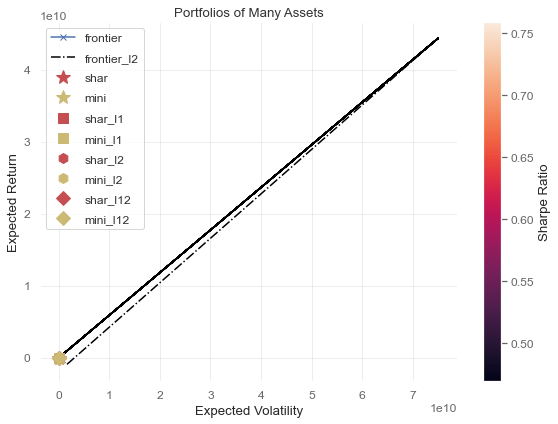

In [75]:
#Create a new figure\n
plt.figure(figsize=(8,6))

#Plot results of MC on portfolio weights\n
plt.scatter(results[0,:], results[1,:], c=results[2,:], marker='o')
plt.plot([np.sqrt(p[1])*np.sqrt(numPeriodsAnnually) for p in efficientPortfolios], predReturn * numPeriodsAnnually , marker='x', label='frontier')
plt.plot([np.sqrt(p[1])*np.sqrt(numPeriodsAnnually) for p in efficientPortfolios_l2], predReturn_l2 * numPeriodsAnnually, linestyle='-.', color='black', label='frontier_l2')
plt.plot(sdpSR*np.sqrt(numPeriodsAnnually), rpSR*numPeriodsAnnually, 'r*', markersize=15.0, label = 'shar')
plt.plot(sdpminVar*np.sqrt(numPeriodsAnnually), rpminVar*numPeriodsAnnually, 'y*', markersize=15.0, label = 'mini')
plt.plot(sdpSRl1*np.sqrt(numPeriodsAnnually), rpSRl1*numPeriodsAnnually, 'rs', markersize=10.0, label = 'shar_l1')
plt.plot(sdpminVarl1*np.sqrt(numPeriodsAnnually), rpminVarl1*numPeriodsAnnually, 'ys', markersize=10.0, label = 'mini_l1')
plt.plot(sdpSRl2*np.sqrt(numPeriodsAnnually), rpSRl2*numPeriodsAnnually, 'rh', markersize=10.0, label = 'shar_l2')
plt.plot(sdpminVarl2*np.sqrt(numPeriodsAnnually), rpminVarl2*numPeriodsAnnually, 'yh', markersize=10.0, label = 'mini_l2')
plt.plot(sdpSRl12*np.sqrt(numPeriodsAnnually), rpSRl12*numPeriodsAnnually, 'rD', markersize=10.0, label = 'shar_l12')
plt.plot(sdpminVarl12*np.sqrt(numPeriodsAnnually), rpminVarl12*numPeriodsAnnually, 'yD', markersize=10.0, label = 'mini_l12')
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.title('Portfolios of Many Assets')
plt.tight_layout()
plt.savefig('Monte Carlo Simulation for Portfolio', dpi=100)
plt.legend(labelspacing=0.8)
# #plt.figure(figsize=(8,6))
# ind = np.arange(numAssets)
# width = 0.35
# fig, ax = plt.subplots(figsize=(8,6))
# rects1 = ax.bar(ind, woptSR, width, color='r', alpha=0.75)
# rects2 = ax.bar(ind + width, woptmin, width, color='b', alpha=0.75)
# ax.set_ylabel('Weight of Asset in Portfolio')
# ax.set_ylim(0,0.6)
# ax.set_title('Comparison of Portfolio Compositions')
# ax.set_xticks(ind + width)
# ax.set_xticklabels(stocks)
# plt.tight_layout()
# ax.legend((rects1[0], rects2[0]), ('Max Sharpe Ratio', 'Minimum Volatility'))
# plt.savefig('Portfolio Compositions', dpi=100)
# plt.show()

In [23]:
def findEfficientFrontier_risk(meanReturns, covMatrix, rangeOfrisk):

    "    Finds the set of portfolios comprising the efficient frontier\n"

    "    INPUT\n",
    "    meanReturns: mean values of each asset's returns\n",
    "    covMatrix: covariance of each asset in the portfolio\n",
    "    targetReturn: APR of target expected return\n",

    "    OUTPUT\n",
    "    Dictionary of results from optimization\n",

    efficientPortfolios = []
    for risk in rangeOfrisk:
        res = meanVariancePortfolioRiskAversion(meanVec = np.array(meanReturns), sigMat = np.array(covMatrix), riskAversion = risk,maxAlloc = 1, longShort = 0, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None)
        efficientPortfolios.append(res)

    return efficientPortfolios

def findEfficientFrontier_risk2(meanReturns, covMatrix, rangeOfrisk):

    "    Finds the set of portfolios comprising the efficient frontier\n"

    "    INPUT\n",
    "    meanReturns: mean values of each asset's returns\n",
    "    covMatrix: covariance of each asset in the portfolio\n",
    "    targetReturn: APR of target expected return\n",

    "    OUTPUT\n",
    "    Dictionary of results from optimization\n",

    efficientPortfolios = []
    for risk in rangeOfrisk:
        res = meanVariancePortfolioRiskAversion(meanVec = np.array(meanReturns), sigMat = np.array(covMatrix), riskAversion = risk,maxAlloc = 1, longShort = 0, lambda_l1 = 0, lambda_l2 = 0.5, assetsOrder = None)
        efficientPortfolios.append(res)

    return efficientPortfolios

In [24]:
"#Find portfolio with maximum Sharpe ratio\n"
woptSR, varSR = maxSharpeRatioPortfolio(meanReturn, np.array(covariance), maxAlloc = 1, longShort = 0, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None)
rpSR, sdpSR = calcPortfolioPerf(woptSR, meanReturn, covariance)
"#Find portfolio with minimum variance\n"
woptSRl1, varSRl1 = maxSharpeRatioPortfolio(meanReturn, np.array(covariance), maxAlloc = 1, longShort = 0, lambda_l1 = 0.5, lambda_l2 = 0, assetsOrder = None)
rpSRl1, sdpSRl1 = calcPortfolioPerf(woptSRl1, meanReturn, covariance)

woptSRl2, varSRl2 = maxSharpeRatioPortfolio(meanReturn, np.array(covariance), maxAlloc = 1, longShort = 0, lambda_l1 = 0, lambda_l2 = 0.5, assetsOrder = None)
rpSRl2, sdpSRl2 = calcPortfolioPerf(woptSRl2, meanReturn, covariance)

woptSRl12, varSRl12 = maxSharpeRatioPortfolio(meanReturn, np.array(covariance), maxAlloc = 1, longShort = 0, lambda_l1 = 0.5, lambda_l2 = 1, assetsOrder = None)
rpSRl12, sdpSRl12 = calcPortfolioPerf(woptSRl12, meanReturn, covariance)

woptmin,varmin = minimumVariancePortfolio(np.array(covariance), maxAlloc = 1, longShort = 0, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None)
rpminVar, sdpminVar = calcPortfolioPerf(woptmin, meanReturn, covariance)

woptminl1,varminl1 = minimumVariancePortfolio(np.array(covariance), maxAlloc = 1, longShort = 0, lambda_l1 = 0.5, lambda_l2 = 0, assetsOrder = None)
rpminVarl1, sdpminVarl1 = calcPortfolioPerf(woptminl1, meanReturn, covariance)

woptminl2,varminl2 = minimumVariancePortfolio(np.array(covariance), maxAlloc = 1, longShort = 0, lambda_l1 = 0, lambda_l2 = 0.5, assetsOrder = None)
rpminVarl2, sdpminVarl2 = calcPortfolioPerf(woptminl2, meanReturn, covariance)

woptminl12,varminl12 = minimumVariancePortfolio(np.array(covariance), maxAlloc = 1, longShort = 0, lambda_l1 = 0.5, lambda_l2 = 0.5, assetsOrder = None)
rpminVarl12, sdpminVarl12 = calcPortfolioPerf(woptminl12, meanReturn, covariance)


risks = np.linspace(0, 1, 1000)
efficientPortfolios_risk = findEfficientFrontier_risk(meanReturn,  covariance, risks)
efficientPortfolios_risk2 = findEfficientFrontier_risk2(meanReturn,  covariance, risks)

In [25]:
predReturn_risk = []
for i in efficientPortfolios_risk:
    predReturn_risk.append(i[0]@meanReturn)
predReturn_risk = np.array(predReturn_risk)
predReturn_risk2 = []
for i in efficientPortfolios_risk2:
    predReturn_risk2.append(i[0]@meanReturn)
predReturn_risk2 = np.array(predReturn_risk2)


C:\Users\16468\AppData\Local\Temp\ipykernel_10628\643759797.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Sharpe Ratio')


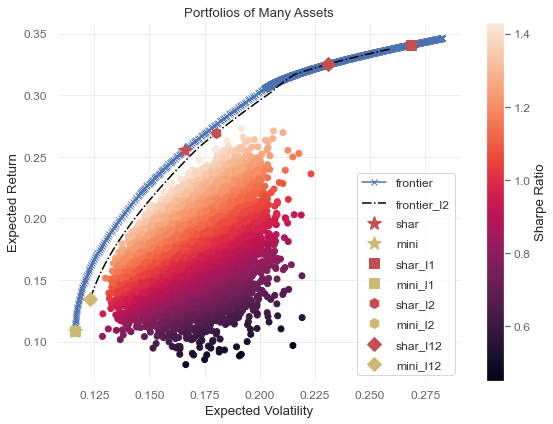

In [26]:
plt.figure(figsize=(8,6))

#Plot results of MC on portfolio weights\n
plt.scatter(results[0,:], results[1,:], c=results[2,:], marker='o')
plt.plot([np.sqrt(p[1])*np.sqrt(numPeriodsAnnually) for p in efficientPortfolios_risk], predReturn_risk * numPeriodsAnnually , marker='x', label='frontier')
plt.plot([np.sqrt(p[1])*np.sqrt(numPeriodsAnnually) for p in efficientPortfolios_risk2], predReturn_risk2 * numPeriodsAnnually, linestyle='-.', color='black', label='frontier_l2')
plt.plot(sdpSR*np.sqrt(numPeriodsAnnually), rpSR*numPeriodsAnnually, 'r*', markersize=15.0, label = 'shar')
plt.plot(sdpminVar*np.sqrt(numPeriodsAnnually), rpminVar*numPeriodsAnnually, 'y*', markersize=15.0, label = 'mini')
plt.plot(sdpSRl1*np.sqrt(numPeriodsAnnually), rpSRl1*numPeriodsAnnually, 'rs', markersize=10.0, label = 'shar_l1')
plt.plot(sdpminVarl1*np.sqrt(numPeriodsAnnually), rpminVarl1*numPeriodsAnnually, 'ys', markersize=10.0, label = 'mini_l1')
plt.plot(sdpSRl2*np.sqrt(numPeriodsAnnually), rpSRl2*numPeriodsAnnually, 'rh', markersize=10.0, label = 'shar_l2')
plt.plot(sdpminVarl2*np.sqrt(numPeriodsAnnually), rpminVarl2*numPeriodsAnnually, 'yh', markersize=10.0, label = 'mini_l2')
plt.plot(sdpSRl12*np.sqrt(numPeriodsAnnually), rpSRl12*numPeriodsAnnually, 'rD', markersize=10.0, label = 'shar_l12')
plt.plot(sdpminVarl12*np.sqrt(numPeriodsAnnually), rpminVarl12*numPeriodsAnnually, 'yD', markersize=10.0, label = 'mini_l12')
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.title('Portfolios of Many Assets')
plt.tight_layout()
plt.savefig('Monte Carlo Simulation for Portfolio', dpi=100)
plt.legend(labelspacing=0.8)
# #plt.figure(figsize=(8,6))
# ind = np.arange(numAssets)
# width = 0.35
# fig, ax = plt.subplots(figsize=(8,6))
# rects1 = ax.bar(ind, woptSR, width, color='r', alpha=0.75)
# rects2 = ax.bar(ind + width, woptmin, width, color='b', alpha=0.75)
# ax.set_ylabel('Weight of Asset in Portfolio')
# ax.set_ylim(0,0.6)
# ax.set_title('Comparison of Portfolio Compositions')
# ax.set_xticks(ind + width)
# ax.set_xticklabels(stocks)
# plt.tight_layout()
# ax.legend((rects1[0], rects2[0]), ('Max Sharpe Ratio', 'Minimum Volatility'))
# plt.savefig('Portfolio Compositions', dpi=100)
# plt.show()

## Long Short RetTarget

In [27]:
def findEfficientFrontier(meanReturns, covMatrix, rangeOfReturns):

    "    Finds the set of portfolios comprising the efficient frontier\n"

    "    INPUT\n",
    "    meanReturns: mean values of each asset's returns\n",
    "    covMatrix: covariance of each asset in the portfolio\n",
    "    targetReturn: APR of target expected return\n",

    "    OUTPUT\n",
    "    Dictionary of results from optimization\n",

    efficientPortfolios = []
    for ret in rangeOfReturns:
        res = meanVariancePortfolioReturnsTarget(meanVec = np.array(meanReturns), sigMat = np.array(covMatrix), maxAlloc = 1, retTarget = ret, longShort = 0.5, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None)
        efficientPortfolios.append(res)

    return efficientPortfolios

def findEfficientFrontier_l1(meanReturns, covMatrix, rangeOfReturns):

    "    Finds the set of portfolios comprising the efficient frontier\n"

    "    INPUT\n",
    "    meanReturns: mean values of each asset's returns\n",
    "    covMatrix: covariance of each asset in the portfolio\n",
    "    targetReturn: APR of target expected return\n",

    "    OUTPUT\n",
    "    Dictionary of results from optimization\n",

    efficientPortfolios = []
    for ret in rangeOfReturns:
        res = meanVariancePortfolioReturnsTarget(meanVec = np.array(meanReturns), sigMat = np.array(covMatrix), maxAlloc = 1, retTarget = ret, longShort = 0.5, lambda_l1 = 0.5, lambda_l2 = 0, assetsOrder = None)
        efficientPortfolios.append(res)

    return efficientPortfolios

In [28]:
"#Find portfolio with maximum Sharpe ratio\n"
woptSR, varSR = maxSharpeRatioPortfolio(meanReturn, np.array(covariance), maxAlloc = 1, longShort = 0.5, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None)
rpSR, sdpSR = calcPortfolioPerf(woptSR, meanReturn, covariance)
"#Find portfolio with minimum variance\n"
woptSRl1, varSRl1 = maxSharpeRatioPortfolio(meanReturn, np.array(covariance), maxAlloc = 1, longShort = 0.5, lambda_l1 = 0.5, lambda_l2 = 0, assetsOrder = None)
rpSRl1, sdpSRl1 = calcPortfolioPerf(woptSRl1, meanReturn, covariance)

woptSRl2, varSRl2 = maxSharpeRatioPortfolio(meanReturn, np.array(covariance), maxAlloc = 1, longShort = 0.5, lambda_l1 = 0, lambda_l2 = 0.5, assetsOrder = None)
rpSRl2, sdpSRl2 = calcPortfolioPerf(woptSRl2, meanReturn, covariance)

woptSRl12, varSRl12 = maxSharpeRatioPortfolio(meanReturn, np.array(covariance), maxAlloc = 1, longShort = 0.5, lambda_l1 = 0.5, lambda_l2 = 0.5, assetsOrder = None)
rpSRl12, sdpSRl12 = calcPortfolioPerf(woptSRl12, meanReturn, covariance)

woptmin,varmin = minimumVariancePortfolio(np.array(covariance), maxAlloc = 1, longShort = 0.5, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None)
rpminVar, sdpminVar = calcPortfolioPerf(woptmin, meanReturn, covariance)

woptminl1,varminl1 = minimumVariancePortfolio(np.array(covariance), maxAlloc = 1, longShort = 0.5, lambda_l1 = 0.5, lambda_l2 = 0, assetsOrder = None)
rpminVarl1, sdpminVarl1 = calcPortfolioPerf(woptminl1, meanReturn, covariance)

woptminl2,varminl2 = minimumVariancePortfolio(np.array(covariance), maxAlloc = 1, longShort = 0.5, lambda_l1 = 0, lambda_l2 = 0.5, assetsOrder = None)
rpminVarl2, sdpminVarl2 = calcPortfolioPerf(woptminl2, meanReturn, covariance)

woptminl12,varminl12 = minimumVariancePortfolio(np.array(covariance), maxAlloc = 1, longShort = 0.5, lambda_l1 = 0.5, lambda_l2 = 0.5, assetsOrder = None)
rpminVarl12, sdpminVarl12 = calcPortfolioPerf(woptminl12, meanReturn, covariance)

targetReturns = np.linspace(rpminVar, max(meanReturn), 100)
# targetReturns = 100*((targetReturns/100 + 1)**250 - 1)
efficientPortfolios = findEfficientFrontier(meanReturn,  covariance, targetReturns)
efficientPortfolios_l1 = findEfficientFrontier_l1(meanReturn,  covariance, targetReturns)

In [29]:
predReturn = []
for i in efficientPortfolios:
    predReturn.append(i[0]@meanReturn)
predReturn = np.array(predReturn)

predReturn_l1 = []
for i in efficientPortfolios_l1:
    predReturn_l1.append(i[0]@meanReturn)
predReturn_l1 = np.array(predReturn_l1)

C:\Users\16468\AppData\Local\Temp\ipykernel_10628\1484288935.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Sharpe Ratio')


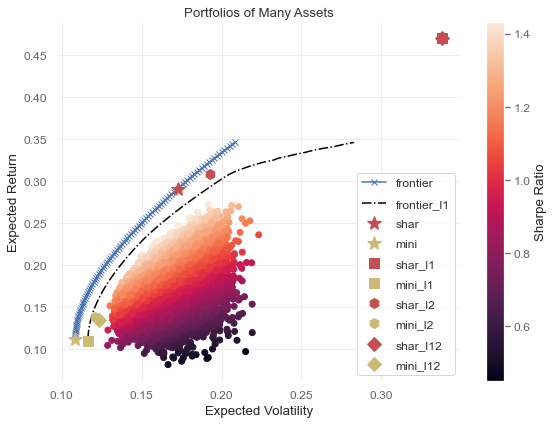

In [30]:
#Create a new figure\n
plt.figure(figsize=(8,6))

#Plot results of MC on portfolio weights\n
plt.scatter(results[0,:], results[1,:], c=results[2,:], marker='o')
plt.plot([np.sqrt(p[1])*np.sqrt(numPeriodsAnnually) for p in efficientPortfolios], predReturn * numPeriodsAnnually , marker='x', label='frontier')
plt.plot([np.sqrt(p[1])*np.sqrt(numPeriodsAnnually) for p in efficientPortfolios_l1], predReturn_l1 * numPeriodsAnnually, linestyle='-.', color='black', label='frontier_l1')
plt.plot(sdpSR*np.sqrt(numPeriodsAnnually), rpSR*numPeriodsAnnually, 'r*', markersize=15.0, label = 'shar')
plt.plot(sdpminVar*np.sqrt(numPeriodsAnnually), rpminVar*numPeriodsAnnually, 'y*', markersize=15.0, label = 'mini')
plt.plot(sdpSRl1*np.sqrt(numPeriodsAnnually), rpSRl1*numPeriodsAnnually, 'rs', markersize=10.0, label = 'shar_l1')
plt.plot(sdpminVarl1*np.sqrt(numPeriodsAnnually), rpminVarl1*numPeriodsAnnually, 'ys', markersize=10.0, label = 'mini_l1')
plt.plot(sdpSRl2*np.sqrt(numPeriodsAnnually), rpSRl2*numPeriodsAnnually, 'rh', markersize=10.0, label = 'shar_l2')
plt.plot(sdpminVarl2*np.sqrt(numPeriodsAnnually), rpminVarl2*numPeriodsAnnually, 'yh', markersize=10.0, label = 'mini_l2')
plt.plot(sdpSRl12*np.sqrt(numPeriodsAnnually), rpSRl12*numPeriodsAnnually, 'rD', markersize=10.0, label = 'shar_l12')
plt.plot(sdpminVarl12*np.sqrt(numPeriodsAnnually), rpminVarl12*numPeriodsAnnually, 'yD', markersize=10.0, label = 'mini_l12')
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.title('Portfolios of Many Assets')
plt.tight_layout()
plt.savefig('Monte Carlo Simulation for Portfolio', dpi=100)
plt.legend(labelspacing=0.8)

## Longshort risk aversion

In [31]:
def findEfficientFrontier_risk(meanReturns, covMatrix, rangeOfrisk):

    "    Finds the set of portfolios comprising the efficient frontier\n"

    "    INPUT\n",
    "    meanReturns: mean values of each asset's returns\n",
    "    covMatrix: covariance of each asset in the portfolio\n",
    "    targetReturn: APR of target expected return\n",

    "    OUTPUT\n",
    "    Dictionary of results from optimization\n",

    efficientPortfolios = []
    for risk in rangeOfrisk:
        res = meanVariancePortfolioRiskAversion(meanVec = np.array(meanReturns), sigMat = np.array(covMatrix), riskAversion = risk,maxAlloc = 1, longShort = 0.5, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None)
        efficientPortfolios.append(res)

    return efficientPortfolios

def findEfficientFrontier_risk1(meanReturns, covMatrix, rangeOfrisk):

    "    Finds the set of portfolios comprising the efficient frontier\n"

    "    INPUT\n",
    "    meanReturns: mean values of each asset's returns\n",
    "    covMatrix: covariance of each asset in the portfolio\n",
    "    targetReturn: APR of target expected return\n",

    "    OUTPUT\n",
    "    Dictionary of results from optimization\n",

    efficientPortfolios = []
    for risk in rangeOfrisk:
        res = meanVariancePortfolioRiskAversion(meanVec = np.array(meanReturns), sigMat = np.array(covMatrix), riskAversion = risk,maxAlloc = 1, longShort = 0.5, lambda_l1 = 0.5, lambda_l2 = 0, assetsOrder = None)
        efficientPortfolios.append(res)

    return efficientPortfolios

In [32]:
"#Find portfolio with maximum Sharpe ratio\n"
woptSR, varSR = maxSharpeRatioPortfolio(meanReturn, np.array(covariance), maxAlloc = 1, longShort = 0.5, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None)
rpSR, sdpSR = calcPortfolioPerf(woptSR, meanReturn, covariance)
"#Find portfolio with minimum variance\n"
woptSRl1, varSRl1 = maxSharpeRatioPortfolio(meanReturn, np.array(covariance), maxAlloc = 1, longShort = 0.5, lambda_l1 = 0.5, lambda_l2 = 0, assetsOrder = None)
rpSRl1, sdpSRl1 = calcPortfolioPerf(woptSRl1, meanReturn, covariance)

woptSRl2, varSRl2 = maxSharpeRatioPortfolio(meanReturn, np.array(covariance), maxAlloc = 1, longShort = 0.5, lambda_l1 = 0, lambda_l2 = 0.5, assetsOrder = None)
rpSRl2, sdpSRl2 = calcPortfolioPerf(woptSRl2, meanReturn, covariance)

woptSRl12, varSRl12 = maxSharpeRatioPortfolio(meanReturn, np.array(covariance), maxAlloc = 1, longShort = 0.5, lambda_l1 = 0.5, lambda_l2 = 1, assetsOrder = None)
rpSRl12, sdpSRl12 = calcPortfolioPerf(woptSRl12, meanReturn, covariance)

woptmin,varmin = minimumVariancePortfolio(np.array(covariance), maxAlloc = 1, longShort = 0.5, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None)
rpminVar, sdpminVar = calcPortfolioPerf(woptmin, meanReturn, covariance)

woptminl1,varminl1 = minimumVariancePortfolio(np.array(covariance), maxAlloc = 1, longShort = 0.5, lambda_l1 = 0.5, lambda_l2 = 0, assetsOrder = None)
rpminVarl1, sdpminVarl1 = calcPortfolioPerf(woptminl1, meanReturn, covariance)

woptminl2,varminl2 = minimumVariancePortfolio(np.array(covariance), maxAlloc = 1, longShort = 0.5, lambda_l1 = 0, lambda_l2 = 0.5, assetsOrder = None)
rpminVarl2, sdpminVarl2 = calcPortfolioPerf(woptminl2, meanReturn, covariance)

woptminl12,varminl12 = minimumVariancePortfolio(np.array(covariance), maxAlloc = 1, longShort = 0.5, lambda_l1 = 0.5, lambda_l2 = 0.5, assetsOrder = None)
rpminVarl12, sdpminVarl12 = calcPortfolioPerf(woptminl12, meanReturn, covariance)


risks = np.linspace(0, 1, 1000)
efficientPortfolios_risk = findEfficientFrontier_risk(meanReturn,  covariance, risks)
efficientPortfolios_risk1 = findEfficientFrontier_risk1(meanReturn,  covariance, risks)

In [33]:
predReturn_risk = []
for i in efficientPortfolios_risk:
    predReturn_risk.append(i[0]@meanReturn)
predReturn_risk = np.array(predReturn_risk)
predReturn_risk1 = []
for i in efficientPortfolios_risk1:
    predReturn_risk1.append(i[0]@meanReturn)
predReturn_risk1 = np.array(predReturn_risk1)

C:\Users\16468\AppData\Local\Temp\ipykernel_10628\1671595582.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Sharpe Ratio')


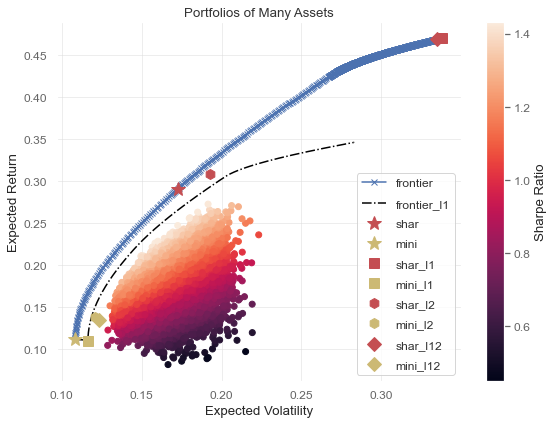

In [34]:
plt.figure(figsize=(8,6))

#Plot results of MC on portfolio weights\n
plt.scatter(results[0,:], results[1,:], c=results[2,:], marker='o')
plt.plot([np.sqrt(p[1])*np.sqrt(numPeriodsAnnually) for p in efficientPortfolios_risk], predReturn_risk * numPeriodsAnnually , marker='x', label='frontier')
plt.plot([np.sqrt(p[1])*np.sqrt(numPeriodsAnnually) for p in efficientPortfolios_risk1], predReturn_risk1 * numPeriodsAnnually, linestyle='-.', color='black', label='frontier_l1')
plt.plot(sdpSR*np.sqrt(numPeriodsAnnually), rpSR*numPeriodsAnnually, 'r*', markersize=15.0, label = 'shar')
plt.plot(sdpminVar*np.sqrt(numPeriodsAnnually), rpminVar*numPeriodsAnnually, 'y*', markersize=15.0, label = 'mini')
plt.plot(sdpSRl1*np.sqrt(numPeriodsAnnually), rpSRl1*numPeriodsAnnually, 'rs', markersize=10.0, label = 'shar_l1')
plt.plot(sdpminVarl1*np.sqrt(numPeriodsAnnually), rpminVarl1*numPeriodsAnnually, 'ys', markersize=10.0, label = 'mini_l1')
plt.plot(sdpSRl2*np.sqrt(numPeriodsAnnually), rpSRl2*numPeriodsAnnually, 'rh', markersize=10.0, label = 'shar_l2')
plt.plot(sdpminVarl2*np.sqrt(numPeriodsAnnually), rpminVarl2*numPeriodsAnnually, 'yh', markersize=10.0, label = 'mini_l2')
plt.plot(sdpSRl12*np.sqrt(numPeriodsAnnually), rpSRl12*numPeriodsAnnually, 'rD', markersize=10.0, label = 'shar_l12')
plt.plot(sdpminVarl12*np.sqrt(numPeriodsAnnually), rpminVarl12*numPeriodsAnnually, 'yD', markersize=10.0, label = 'mini_l12')
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.title('Portfolios of Many Assets')
plt.tight_layout()
plt.savefig('Monte Carlo Simulation for Portfolio', dpi=100)
plt.legend(labelspacing=0.8)
# #plt.figure(figsize=(8,6))
# ind = np.arange(numAssets)
# width = 0.35
# fig, ax = plt.subplots(figsize=(8,6))
# rects1 = ax.bar(ind, woptSR, width, color='r', alpha=0.75)
# rects2 = ax.bar(ind + width, woptmin, width, color='b', alpha=0.75)
# ax.set_ylabel('Weight of Asset in Portfolio')
# ax.set_ylim(0,0.6)
# ax.set_title('Comparison of Portfolio Compositions')
# ax.set_xticks(ind + width)
# ax.set_xticklabels(stocks)
# plt.tight_layout()
# ax.legend((rects1[0], rects2[0]), ('Max Sharpe Ratio', 'Minimum Volatility'))
# plt.savefig('Portfolio Compositions', dpi=100)
# plt.show()

## rolling window backtest

In [35]:
def check_missing(df_logret):
    """
        function to check the missing values and delete the stocks with missing value
        
        Parameters
        ----------
        df_logret : pandas.core.frame.DataFrame
           the price window
            
        Returns
        -------
        res : pandas.core.frame.DataFrame
           the price window without missing value
    """
    df_logret = df_logret.transpose()
    flag = np.zeros(len(df_logret))
    for i in range(len(df_logret)):
        if df_logret.iloc[i,:].isnull().any():
            flag[i] = 0
        else:
            flag[i] = 1
    df_logret['missing_flag'] = flag
    res = df_logret.loc[df_logret['missing_flag'] == 1]
    return res.transpose()

In [36]:
def rollingwindow_backtest_mini(df1, window_size, rebalance_time, maxAlloc = 1, longShort = 0, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None):
    """
        function do the roolingwindow test
        
        Parameters
        ----------
        data : pandas.core.frame.DataFrame

        whindow_size : int 
            parameter for the size of rolling window
        rebalance_time : int
            rebalance time of rolling window test
            
        Returns
        -------
        R : 2d array
            return matrix depends on the rebalance time
        logret: pandas.core.frame.DataFrame
            log return matrix for each stocks
        w_all: 2d array
            optimal weight for each revalance time
        rownames: array
            date time for returns
    """
    
    df_logret = 100*(np.log(df1) - np.log(df1.shift(1)))
    df_logret = df_logret[1:]
    logret = np.array(df_logret)
    
    n = logret.shape[0]
    d = rebalance_time
    start = window_size
    R = None
    portfolio_return = None
    w_all = None
    for i in range(start, n, d):
        k = 0
        #import pdb; pdb.set_trace()
        w_opt = np.zeros(df1.shape[1])
        window = check_missing(df_logret[i-window_size:i]/100)
        m = window.shape[0]
        sample_stocks = window.columns
        logret_window = np.array(window.iloc[:n-1])
        sigMat = np.cov(logret_window, rowvar = False)
        meanVec = np.mean(logret_window, axis = 0)
        w_sample, V = minimumVariancePortfolio(sigMat, maxAlloc, longShort, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None)
        for j in range(df1.shape[1]):
            if df1.columns[j] in sample_stocks:
                w_opt[j] = w_sample[k]
                k += 1
        #import pdb; pdb.set_trace()
        if w_all is None:
            w_all = w_opt
        else:
            w_all = np.vstack([w_all, w_opt])
        if (i+d) < n :
            if R is None:
                logret_sample = np.nan_to_num(logret[i:i+d], nan=0)
                simple_returns = 100*(math.exp(1)**(logret_sample/100) - 1)
                R = np.dot(w_opt, simple_returns.transpose())
            else:
                logret_sample = np.nan_to_num(logret[i:i+d], nan=0)
                simple_returns = 100*(math.exp(1)**(logret_sample/100) - 1)
                R = np.hstack([R, np.dot(w_opt, simple_returns.transpose())])
        elif (i+d) >= n:
            logret_sample = np.nan_to_num(logret[i:], nan=0)
            simple_returns = 100*(math.exp(1)**(logret_sample/100) - 1)
            R = np.hstack([R, np.dot(w_opt, simple_returns.transpose())])
    rownames = df1.index[start+1:]
    return R, df_logret, w_all, rownames

In [37]:
def rollingwindow_backtest_shar(df1, window_size, rebalance_time, maxAlloc = 1, longShort = 0, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None):
    """
        function do the roolingwindow test
        
        Parameters
        ----------
        data : pandas.core.frame.DataFrame

        whindow_size : int 
            parameter for the size of rolling window
        rebalance_time : int
            rebalance time of rolling window test
            
        Returns
        -------
        R : 2d array
            return matrix depends on the rebalance time
        logret: pandas.core.frame.DataFrame
            log return matrix for each stocks
        w_all: 2d array
            optimal weight for each revalance time
        rownames: array
            date time for returns
    """
    
    df_logret = 100*(np.log(df1) - np.log(df1.shift(1)))
    df_logret = df_logret[1:]
    logret = np.array(df_logret)
    
    n = logret.shape[0]
    d = rebalance_time
    start = window_size
    R = None
    portfolio_return = None
    w_all = None
    for i in range(start, n, d):
        k = 0
        #import pdb; pdb.set_trace()
        w_opt = np.zeros(df1.shape[1])
        window = check_missing(df_logret[i-window_size:i]/100)
        m = window.shape[0]
        sample_stocks = window.columns
        logret_window = np.array(window.iloc[:n-1])
        sigMat = np.cov(logret_window, rowvar = False)
        meanVec = np.mean(logret_window, axis = 0)
        w_sample, V = maxSharpeRatioPortfolio(meanVec, sigMat, maxAlloc, longShort, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None)
        for j in range(df1.shape[1]):
            if df1.columns[j] in sample_stocks:
                w_opt[j] = w_sample[k]
                k += 1
        #import pdb; pdb.set_trace()
        if w_all is None:
            w_all = w_opt
        else:
            w_all = np.vstack([w_all, w_opt])
        if (i+d) < n :
            if R is None:
                logret_sample = np.nan_to_num(logret[i:i+d], nan=0)
                simple_returns = 100*(math.exp(1)**(logret_sample/100) - 1)
                R = np.dot(w_opt, simple_returns.transpose())
            else:
                logret_sample = np.nan_to_num(logret[i:i+d], nan=0)
                simple_returns = 100*(math.exp(1)**(logret_sample/100) - 1)
                R = np.hstack([R, np.dot(w_opt, simple_returns.transpose())])
        elif (i+d) >= n:
            logret_sample = np.nan_to_num(logret[i:], nan=0)
            simple_returns = 100*(math.exp(1)**(logret_sample/100) - 1)
            R = np.hstack([R, np.dot(w_opt, simple_returns.transpose())])
    rownames = df1.index[start+1:]
    return R, df_logret, w_all, rownames

In [38]:
def rollingwindow_backtest_ret(df1, window_size, rebalance_time, retTarget, maxAlloc = 1, longShort = 0, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None):
    """
        function do the roolingwindow test
        
        Parameters
        ----------
        data : pandas.core.frame.DataFrame

        whindow_size : int 
            parameter for the size of rolling window
        rebalance_time : int
            rebalance time of rolling window test
            
        Returns
        -------
        R : 2d array
            return matrix depends on the rebalance time
        logret: pandas.core.frame.DataFrame
            log return matrix for each stocks
        w_all: 2d array
            optimal weight for each revalance time
        rownames: array
            date time for returns
    """
    
    df_logret = 100*(np.log(df1) - np.log(df1.shift(1)))
    df_logret = df_logret[1:]
    logret = np.array(df_logret)
    
    n = logret.shape[0]
    d = rebalance_time
    start = window_size
    R = None
    portfolio_return = None
    w_all = None
    for i in range(start, n, d):
        k = 0
        #import pdb; pdb.set_trace()
        w_opt = np.zeros(df1.shape[1])
        window = check_missing(df_logret[i-window_size:i]/100)
        m = window.shape[0]
        sample_stocks = window.columns
        logret_window = np.array(window.iloc[:n-1])
        sigMat = np.cov(logret_window, rowvar = False)
        meanVec = np.mean(logret_window, axis = 0)
        w_sample, V = meanVariancePortfolioReturnsTarget(meanVec,sigMat,retTarget,longShort,maxAlloc=1,lambda_l1=0,lambda_l2=0,assetsOrder=None,)
        for j in range(df1.shape[1]):
            if df1.columns[j] in sample_stocks:
                w_opt[j] = w_sample[k]
                k += 1
        #import pdb; pdb.set_trace()
        if w_all is None:
            w_all = w_opt
        else:
            w_all = np.vstack([w_all, w_opt])
        if (i+d) < n :
            if R is None:
                logret_sample = np.nan_to_num(logret[i:i+d], nan=0)
                simple_returns = 100*(math.exp(1)**(logret_sample/100) - 1)
                R = np.dot(w_opt, simple_returns.transpose())
            else:
                logret_sample = np.nan_to_num(logret[i:i+d], nan=0)
                simple_returns = 100*(math.exp(1)**(logret_sample/100) - 1)
                R = np.hstack([R, np.dot(w_opt, simple_returns.transpose())])
        elif (i+d) >= n:
            logret_sample = np.nan_to_num(logret[i:], nan=0)
            simple_returns = 100*(math.exp(1)**(logret_sample/100) - 1)
            R = np.hstack([R, np.dot(w_opt, simple_returns.transpose())])
    rownames = df1.index[start+1:]
    return R, df_logret, w_all, rownames

In [39]:
def rollingwindow_backtest_risk(df1, window_size, rebalance_time, riskAversion, maxAlloc = 1, longShort = 0, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None):
    """
        function do the roolingwindow test
        
        Parameters
        ----------
        data : pandas.core.frame.DataFrame

        whindow_size : int 
            parameter for the size of rolling window
        rebalance_time : int
            rebalance time of rolling window test
            
        Returns
        -------
        R : 2d array
            return matrix depends on the rebalance time
        logret: pandas.core.frame.DataFrame
            log return matrix for each stocks
        w_all: 2d array
            optimal weight for each revalance time
        rownames: array
            date time for returns
    """
    
    df_logret = 100*(np.log(df1) - np.log(df1.shift(1)))
    df_logret = df_logret[1:]
    logret = np.array(df_logret)
    
    n = logret.shape[0]
    d = rebalance_time
    start = window_size
    R = None
    portfolio_return = None
    w_all = None
    for i in range(start, n, d):
        k = 0
        #import pdb; pdb.set_trace()
        w_opt = np.zeros(df1.shape[1])
        window = check_missing(df_logret[i-window_size:i]/100)
        m = window.shape[0]
        sample_stocks = window.columns
        logret_window = np.array(window.iloc[:n-1])
        sigMat = np.cov(logret_window, rowvar = False)
        meanVec = np.mean(logret_window, axis = 0)
        w_sample, V = meanVariancePortfolioRiskAversion(meanVec, sigMat, riskAversion, maxAlloc, longShort, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None)
        for j in range(df1.shape[1]):
            if df1.columns[j] in sample_stocks:
                w_opt[j] = w_sample[k]
                k += 1
        #import pdb; pdb.set_trace()
        if w_all is None:
            w_all = w_opt
        else:
            w_all = np.vstack([w_all, w_opt])
        if (i+d) < n :
            if R is None:
                logret_sample = np.nan_to_num(logret[i:i+d], nan=0)
                simple_returns = 100*(math.exp(1)**(logret_sample/100) - 1)
                R = np.dot(w_opt, simple_returns.transpose())
            else:
                logret_sample = np.nan_to_num(logret[i:i+d], nan=0)
                simple_returns = 100*(math.exp(1)**(logret_sample/100) - 1)
                R = np.hstack([R, np.dot(w_opt, simple_returns.transpose())])
        elif (i+d) >= n:
            logret_sample = np.nan_to_num(logret[i:], nan=0)
            simple_returns = 100*(math.exp(1)**(logret_sample/100) - 1)
            R = np.hstack([R, np.dot(w_opt, simple_returns.transpose())])
    rownames = df1.index[start+1:]
    return R, df_logret, w_all, rownames

In [40]:
R1, logret1, w_all1, names1 = rollingwindow_backtest_mini(data, window_size = 252, rebalance_time = 20, maxAlloc = 1, longShort = 0, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None)
R2, logret2, w_all2, names2 = rollingwindow_backtest_shar(data, window_size = 252, rebalance_time = 20, maxAlloc = 1, longShort = 0, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None)
R3, logret3, w_all3, names3 = rollingwindow_backtest_ret(data, window_size = 252, rebalance_time = 20, retTarget = 0.5, maxAlloc = 1, longShort = 0, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None)
R4, logret4, w_all4, names4 = rollingwindow_backtest_risk(data, window_size = 252, rebalance_time = 20, riskAversion = 0.1, maxAlloc = 1, longShort = 0, lambda_l1 = 0, lambda_l2 = 0, assetsOrder = None)

In [41]:
D1 = pd.Series(R1, index = names1)
D2 = pd.Series(R2, index = names1)
D3 = pd.Series(R3, index = names1)
D4 = pd.Series(R4, index = names1)

In [42]:
qs.reports.html(D1/100, "SPY", output='C:/Users/16468/Documents/Stony Brook/Executive Education/MySlides/Code/mini.html')
qs.reports.html(D2/100, "SPY", output='C:/Users/16468/Documents/Stony Brook/Executive Education/MySlides/Code/shar.html')
qs.reports.html(D3/100, "SPY", output='C:/Users/16468/Documents/Stony Brook/Executive Education/MySlides/Code/ret.html')
qs.reports.html(D4/100, "SPY", output='C:/Users/16468/Documents/Stony Brook/Executive Education/MySlides/Code/risk.html')